In [1]:
from md4.configs.hollow_md4.text8 import get_config
from collections.abc import Callable, Mapping, Sequence
import copy
import functools
from typing import Any

from absl import logging
from clu import metric_writers
from clu import metrics
from clu import parameter_overview
from clu import periodic_actions
from etils import epath
import flax
import flax.jax_utils as flax_utils
import flax.linen as nn
import grain.python as graåçin
import jax
from jax.experimental import checkify
import jax.numpy as jnp
import ml_collections
import numpy as np
import optax
from orbax import checkpoint as orbax_checkpoint

from md4 import input_pipeline
from md4 import input_pipeline_v2
from md4 import sampling
from md4 import utils
from md4.models import utils as model_utils

from md4.train import *
from md4.train import _get_checkpoint_manager

import pickle
from tqdm import tqdm

config = get_config()
workdir = "/root/md4/expt_contantlr_deeper__model_untie"

2025-04-09 00:59:47.968558: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744160387.983176   10047 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744160387.987530   10047 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744160387.998432   10047 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744160387.998444   10047 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744160387.998446   10047 computation_placer.cc:177] computation placer alr

cv2 not found


In [2]:
workdir = epath.Path(workdir)
workdir.mkdir(parents=True, exist_ok=True)

rng = utils.get_rng(config.seed)
logging.info("Using random seed %s.", rng)
writer = metric_writers.create_default_writer(
    workdir, just_logging=jax.process_index() > 0
)

# Learning rate schedule.
assert config.batch_size % jax.device_count() == 0
per_device_batch_size = config.batch_size // jax.device_count()
num_train_steps = input_pipeline.get_num_train_steps(config)
steps_per_epoch = num_train_steps // config.num_epochs
logging.info("num_train_steps=%d, steps_per_epoch=%d", num_train_steps, steps_per_epoch)
schedule_fn = functools.partial(
    get_learning_rate,
    base_learning_rate=config.learning_rate,
    num_steps=num_train_steps,
    warmup_steps=config.warmup_steps,
    schedule_type=config.learning_rate_schedule,
)

# Build input pipeline.
rng, data_seed = jax.random.split(rng)
data_seed = int(
    jax.random.randint(data_seed, [], minval=0, maxval=np.iinfo(np.int32).max)
)
# The input pipeline runs on each process and loads data for local TPUs.
create_datasets = (
    input_pipeline_v2.create_datasets
    if config.get("use_v2_input_pipeline", None)
    else input_pipeline.create_datasets
)
train_loader, eval_loaders, dataset_info = create_datasets(config, data_seed)

train_iter = iter(train_loader)

# Initialize model.
rng, model_rng = jax.random.split(rng)
data_shape = input_pipeline.get_data_shape(config)
# Note: parameters are initialized in half precision if mixed_precision_training=True
# We could also try casting them to half precision here
model, optimizer, train_state, metrics_class = (
    create_train_state(  # pylint: disable=invalid-name
        config,
        model_rng,
        input_shape=(per_device_batch_size // config.num_microbatches,) + data_shape,
        schedule_fn=schedule_fn,
    )
)

# Set up checkpointing of the model and the input pipeline.
checkpoint_manager = _get_checkpoint_manager(config, workdir)

# Retrieve data from previous checkpoints if possible.
checkpointed_state = dict(train_state=train_state, train_iter=train_iter)
if checkpoint_manager.latest_step() is not None:
    checkpointed_state = checkpoint_manager.restore(
        checkpoint_manager.latest_step(), items=checkpointed_state
    )
train_state = checkpointed_state["train_state"]
train_iter = checkpointed_state["train_iter"]

I0000 00:00:1744160397.094504   10047 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78760 MB memory:  -> device: 0, name: NVIDIA H100 80GB HBM3, pci bus id: 0000:18:00.0, compute capability: 9.0
I0000 00:00:1744160397.096927   10047 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 78772 MB memory:  -> device: 1, name: NVIDIA H100 80GB HBM3, pci bus id: 0000:2a:00.0, compute capability: 9.0
I0000 00:00:1744160397.098965   10047 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 78772 MB memory:  -> device: 2, name: NVIDIA H100 80GB HBM3, pci bus id: 0000:3a:00.0, compute capability: 9.0
I0000 00:00:1744160397.100985   10047 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 78772 MB memory:  -> device: 3, name: NVIDIA H100 80GB HBM3, pci bus id: 0000:5d:00.0, compute capability: 9.0
I0000 00:00:1744160397.103452   10047 gpu_device.cc:2019] Create

In [3]:
# Distribute training.
train_state = flax_utils.replicate(train_state)
train_step_func = functools.partial(
    train_step,
    model=model,
    optimizer=optimizer,
    train_metrics_class=metrics_class,
    learning_rate_fn=schedule_fn,
    ema_rate=config.ema_rate,
    num_microbatches=config.get("num_microbatches", None),
)
if config.check_nans:
    train_step_func = checkify.checkify(train_step_func, errors=checkify.float_checks)
p_train_step = jax.pmap(train_step_func, axis_name="batch", donate_argnums=(0,))
p_eval_step = jax.pmap(
    functools.partial(
        eval_step,
        model=model,
        eval_metrics_class=metrics_class,
        ema_rate=config.ema_rate,
    ),
    axis_name="batch",
)

hooks = []
report_progress = periodic_actions.ReportProgress(
    num_train_steps=num_train_steps, writer=writer
)
if jax.process_index() == 0:
    hooks += [
        report_progress,
        periodic_actions.Profile(num_profile_steps=5, logdir=workdir),
    ]
train_metrics = None

# Unreplicating from TPU is costly, so we only do it once at the start.
initial_step = int(flax.jax_utils.unreplicate(train_state.step))

In [4]:
batch = utils.reshape_batch(next(train_iter))

if config.check_nans:
    errs, (train_state, metrics_update) = p_train_step(
        train_state=train_state, batch=batch
    )
    errs.throw()
else:
    train_state, metrics_update = p_train_step(train_state=train_state, batch=batch)
metric_update = flax_utils.unreplicate(metrics_update)

train_metrics = (
    metric_update if train_metrics is None else train_metrics.merge(metric_update)
)

2025-04-09 01:00:55.196770: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-09 01:00:55.202715: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744160455.209912   12683 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744160455.214002   12683 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
E0000 00:00:1744160455.215880   12692 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744160455.220007   12692 cuda_blas.cc:1

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
batch_size 64
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


In [5]:
model.sampler = "gibbs"

results_dict = {}

k_range = [32]
tem_range = [0.1, 1.0, 2.0, 10.0, 1000.0]

# for k in k_range:
#     for tem in tem_range:
#         results_dict[k, tem] = {}

timesteps = 16
model.timesteps = timesteps // 2

for k in tqdm(k_range):
    for tem in tqdm(tem_range):
        model.k = k
        model.gibbs_temp = tem
        # for timesteps in tqdm([16, 32, 64, 128, 256]):
        #     model.timesteps = timesteps
        # with report_progress.timed("sample"):
        _, sample_rng = jax.random.split(rng)
        dummy_loader = train_loader
        dummy_batch = utils.reshape_batch(next(iter(dummy_loader)))
        dummy_inputs = dummy_batch[config.task_type]
        if "label" in dummy_batch:
            conditioning = dummy_batch["label"].astype("int32")
        else:
            conditioning = None

        samples = sampling.generate(
            model,
            train_state,
            flax_utils.replicate(sample_rng),
            dummy_inputs,
            conditioning=conditioning,
        )

        all_samples = jax.pmap(
            lambda x: jax.lax.all_gather(x, "batch"), axis_name="batch"
        )(samples)
        all_samples = flax_utils.unreplicate(all_samples)
        all_samples = all_samples.reshape(-1, *data_shape)

        tokenizer = dataset_info["tokenizer"]
        texts = utils.detokenize_texts(all_samples, tokenizer)
        results_dict[k, tem] = texts

  0%|          | 0/1 [00:00<?, ?it/s]2025-04-09 01:03:39.833712: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-09 01:03:39.844054: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-09 01:03:39.845386: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744160619.848538   16659 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744160619.853032   16659 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has alre

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


2025-04-09 01:05:11.429411: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744160711.442778   20329 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744160711.446916   20329 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744160711.456923   20329 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744160711.456937   20329 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744160711.456939   20329 computation_placer.cc:177] computation placer alr

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


2025-04-09 01:06:42.164710: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744160802.178206   22326 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744160802.182416   22326 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744160802.192656   22326 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744160802.192671   22326 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744160802.192673   22326 computation_placer.cc:177] computation placer alr

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


2025-04-09 01:08:00.905030: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-09 01:08:00.905030: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744160880.918200   24702 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744160880.918202   24770 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744160880.922370   24770 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
E0000 00:00:1744160880.922374   24702 cuda_blas.cc:1

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


2025-04-09 01:08:09.610192: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-09 01:08:09.610191: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-09 01:08:09.610191: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-09 01:08:09.616598: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744160889.623411   26989 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already b

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


100%|██████████| 1/1 [05:50<00:00, 350.63s/it]


In [11]:
with open(
    f"/root/md4/data_dir/text8/informed_corrector_generations_{timesteps}.pkl", "wb"
) as f:
    pickle.dump(results_dict, f)

In [7]:
with open("/root/md4/data_dir/text8/informed_corrector_generations_16.pkl", "rb") as f:
    results_dict_old = pickle.load(f)

In [10]:
results_dict_old.keys()

dict_keys([(1, 0.1), (1, 1.0), (1, 2.0), (1, 10.0), (1, 1000.0), (2, 0.1), (2, 1.0), (2, 2.0), (2, 10.0), (2, 1000.0), (4, 0.1), (4, 1.0), (4, 2.0), (4, 10.0), (4, 1000.0), (8, 0.1), (8, 1.0), (8, 2.0), (8, 10.0), (8, 1000.0), (16, 0.1), (16, 1.0), (16, 2.0), (16, 10.0), (16, 1000.0), (32, 0.1), (32, 1.0), (32, 2.0), (32, 10.0), (32, 1000.0)])

In [8]:
with open("/root/md4/data_dir/text8/text8_vocab.pkl", "rb") as f:
    vocab = pickle.load(f)

In [9]:
acc_dict = {}

for timesteps, texts in results_dict.items():
    concated = " ".join(texts)
    generated_words = concated.split()
    len(texts), len(generated_words)

    # check if generated words are in vocab
    s = 0
    for word in tqdm(generated_words):
        if word in vocab:
            s += 1
    print(s / len(generated_words))
    acc_dict[timesteps] = s / len(generated_words)
with open("/root/md4/data_dir/text8/baseline_acc.pkl", "wb") as f:
    pickle.dump(acc_dict, f)

100%|██████████| 22911/22911 [00:19<00:00, 1200.77it/s]


0.7461044912923923


100%|██████████| 22837/22837 [00:17<00:00, 1287.36it/s]


0.8284363094977449


100%|██████████| 22896/22896 [00:17<00:00, 1340.16it/s]


0.8732092941998603


100%|██████████| 22897/22897 [00:16<00:00, 1371.37it/s]


0.89815259641001


100%|██████████| 22697/22697 [00:16<00:00, 1373.87it/s]

0.9017050711547782


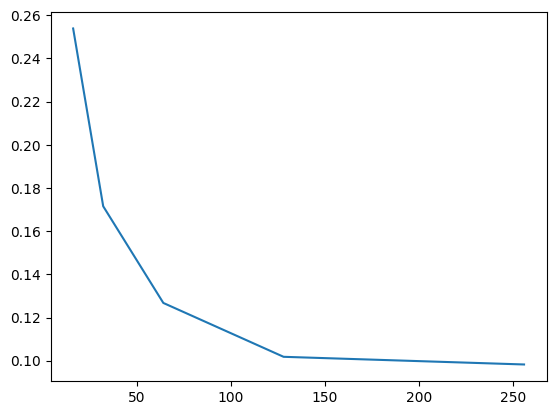

In [10]:
from matplotlib import pyplot as plt

plt.plot(np.array(list(acc_dict.keys())), 1 - np.array(list(acc_dict.values())))

In [11]:
model.sampler

'ancestral'